In [1]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester

import seaborn as sns

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 34)

In [6]:
filter_indices = SampleMeta["Phenotype"].isin(['CRC', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(2893, 34)

In [7]:
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(2893, 903)

In [8]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


# Define and Train Model

In [9]:
# random seed here deals with model initialization

MyAdaBoost = AdaBoostClassifier(base_estimator=None, random_state=42)
param_space = {'n_estimators': np.arange(10, 260, 10)}
AdaBoostCV = GridSearchCV(MyAdaBoost, param_grid=param_space, 
                          cv=5, scoring=metrics.make_scorer(metrics.balanced_accuracy_score),
                         verbose=1)
MyTrainer = Trainer(model = AdaBoostCV, scale_X = True, use_pca = True, n_components=100)
# random seed used in class definition is not used in final output models
MyTrainTester = TrainTester(MyTrainer, metrics.balanced_accuracy_score)
# note that random seed here affects sequence of seeds passed to making new TrainTester objects
# using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
# across all data splits
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)

In [10]:
y = SampleMeta['Phenotype'].to_numpy() == 'Healthy'
y = y.astype('int64')

In [11]:
MyMultiTrainTester.train(MatrixData, y)

Running for split 1 of 5
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  5.0min finished


Running for split 2 of 5
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  5.1min finished


Running for split 3 of 5
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  5.0min finished


Running for split 4 of 5
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  5.0min finished


Running for split 5 of 5
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  5.0min finished


In [12]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.999764,train
1,0.922969,train
2,0.989466,train
3,0.961870,train
4,0.999290,train
0,0.716166,test
1,0.684750,test
2,0.718198,test
3,0.726320,test
4,0.732596,test


<AxesSubplot:xlabel='stage', ylabel='score'>

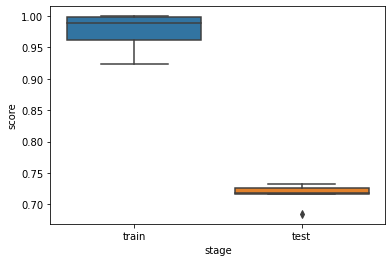

In [13]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [14]:
hyperparams = {'n_estimators': []}
for i in range(n_splits):
    hyperparams['n_estimators'].append(MyMultiTrainTester.TrainerList[i].model.best_params_['n_estimators'])

In [15]:
pd.DataFrame(hyperparams)

,n_estimators
0,250
1,90
2,180
3,110
4,240


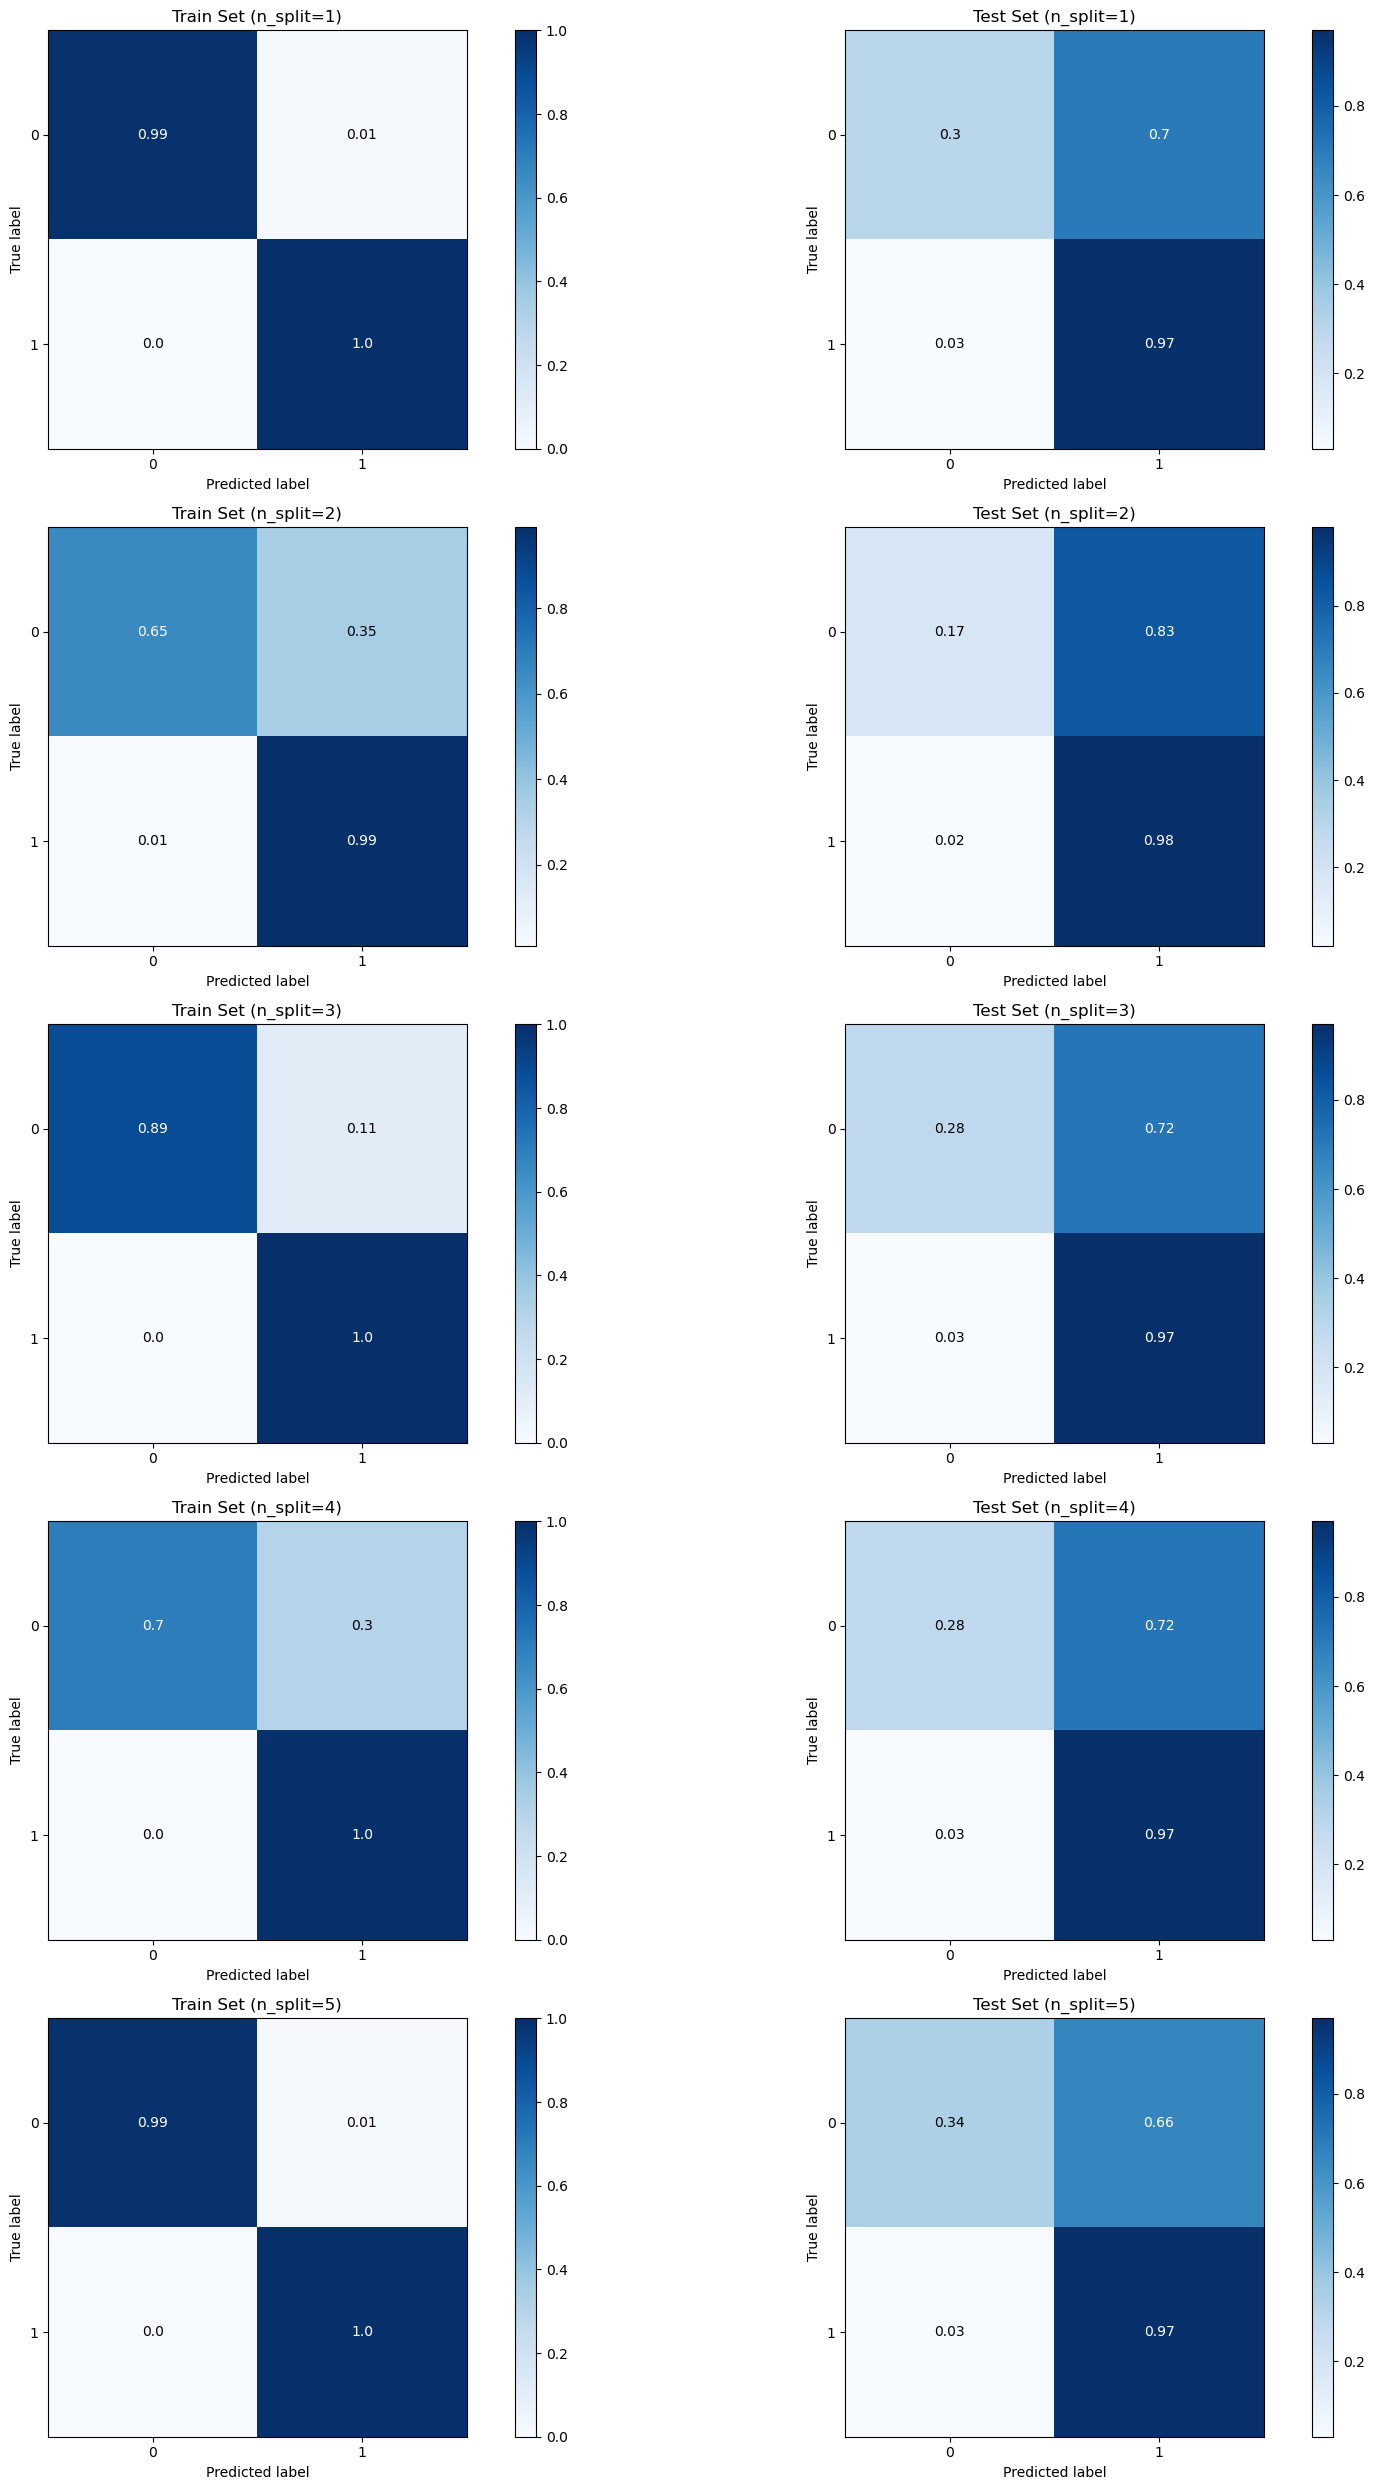

In [16]:
MyMultiTrainTester.plot_confusion(normalize=True)

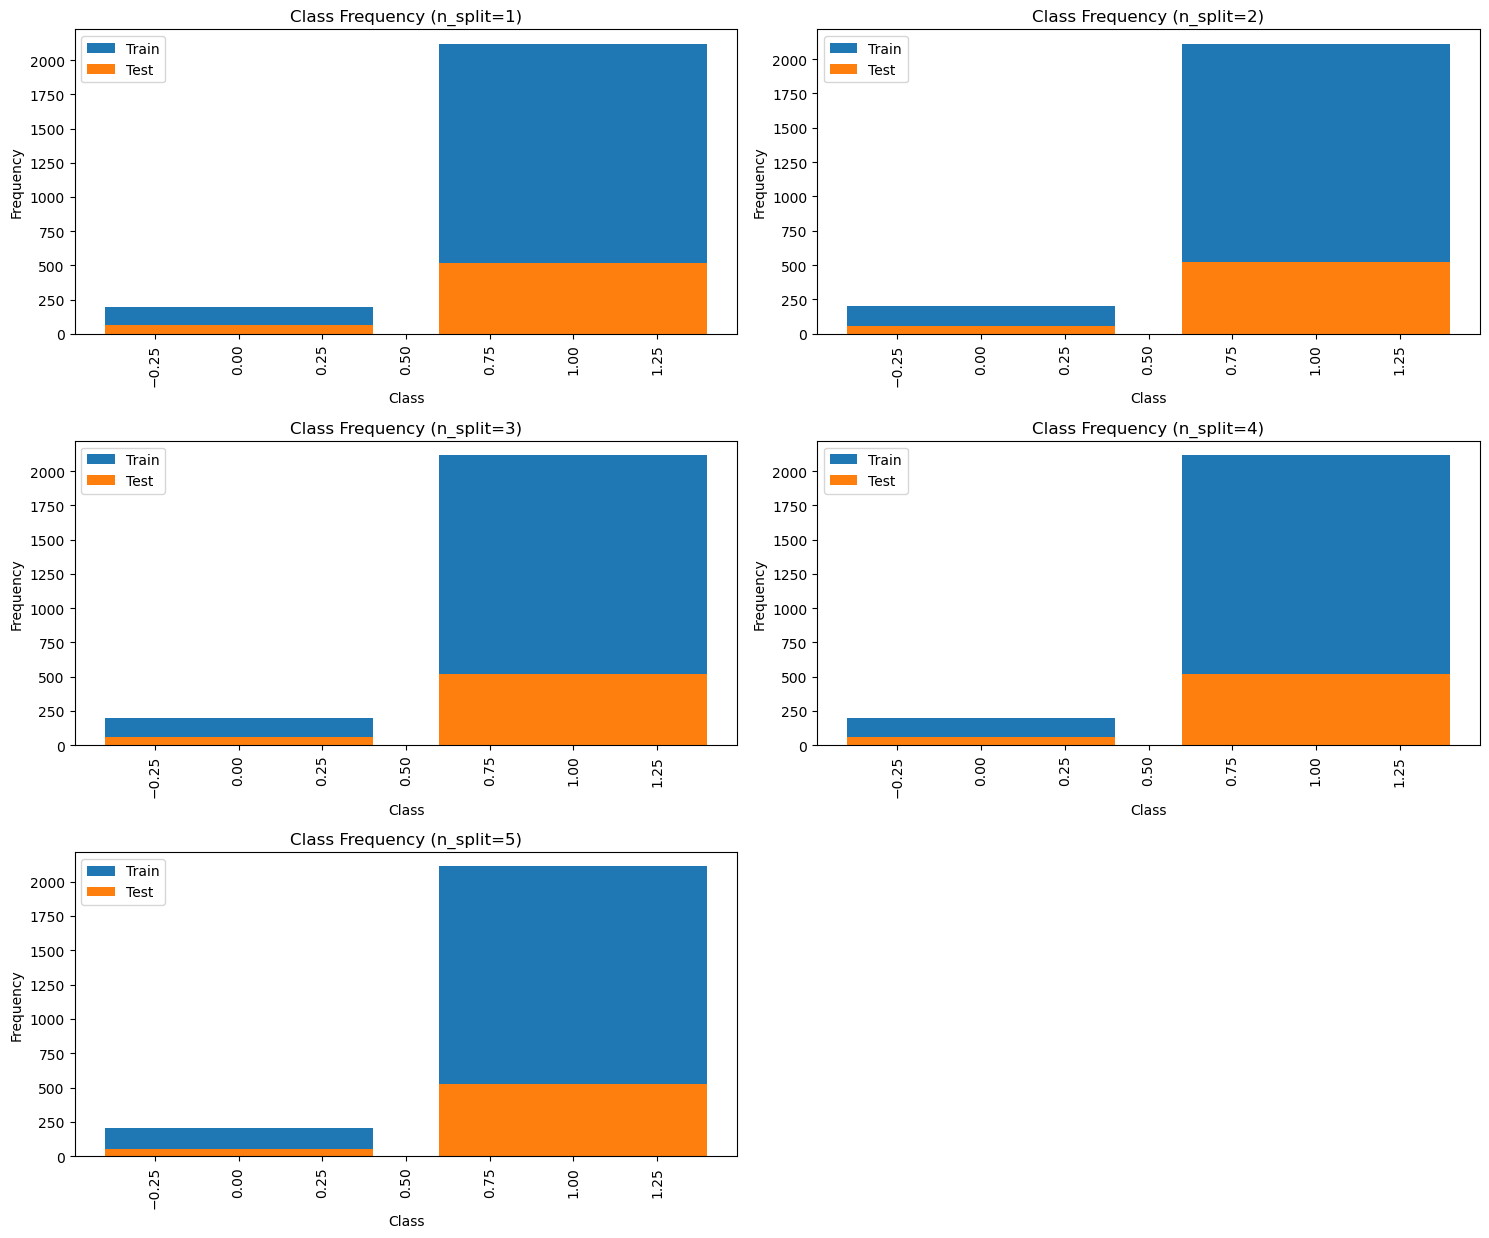

In [17]:
MyMultiTrainTester.plot_class_freq(normalize=True)

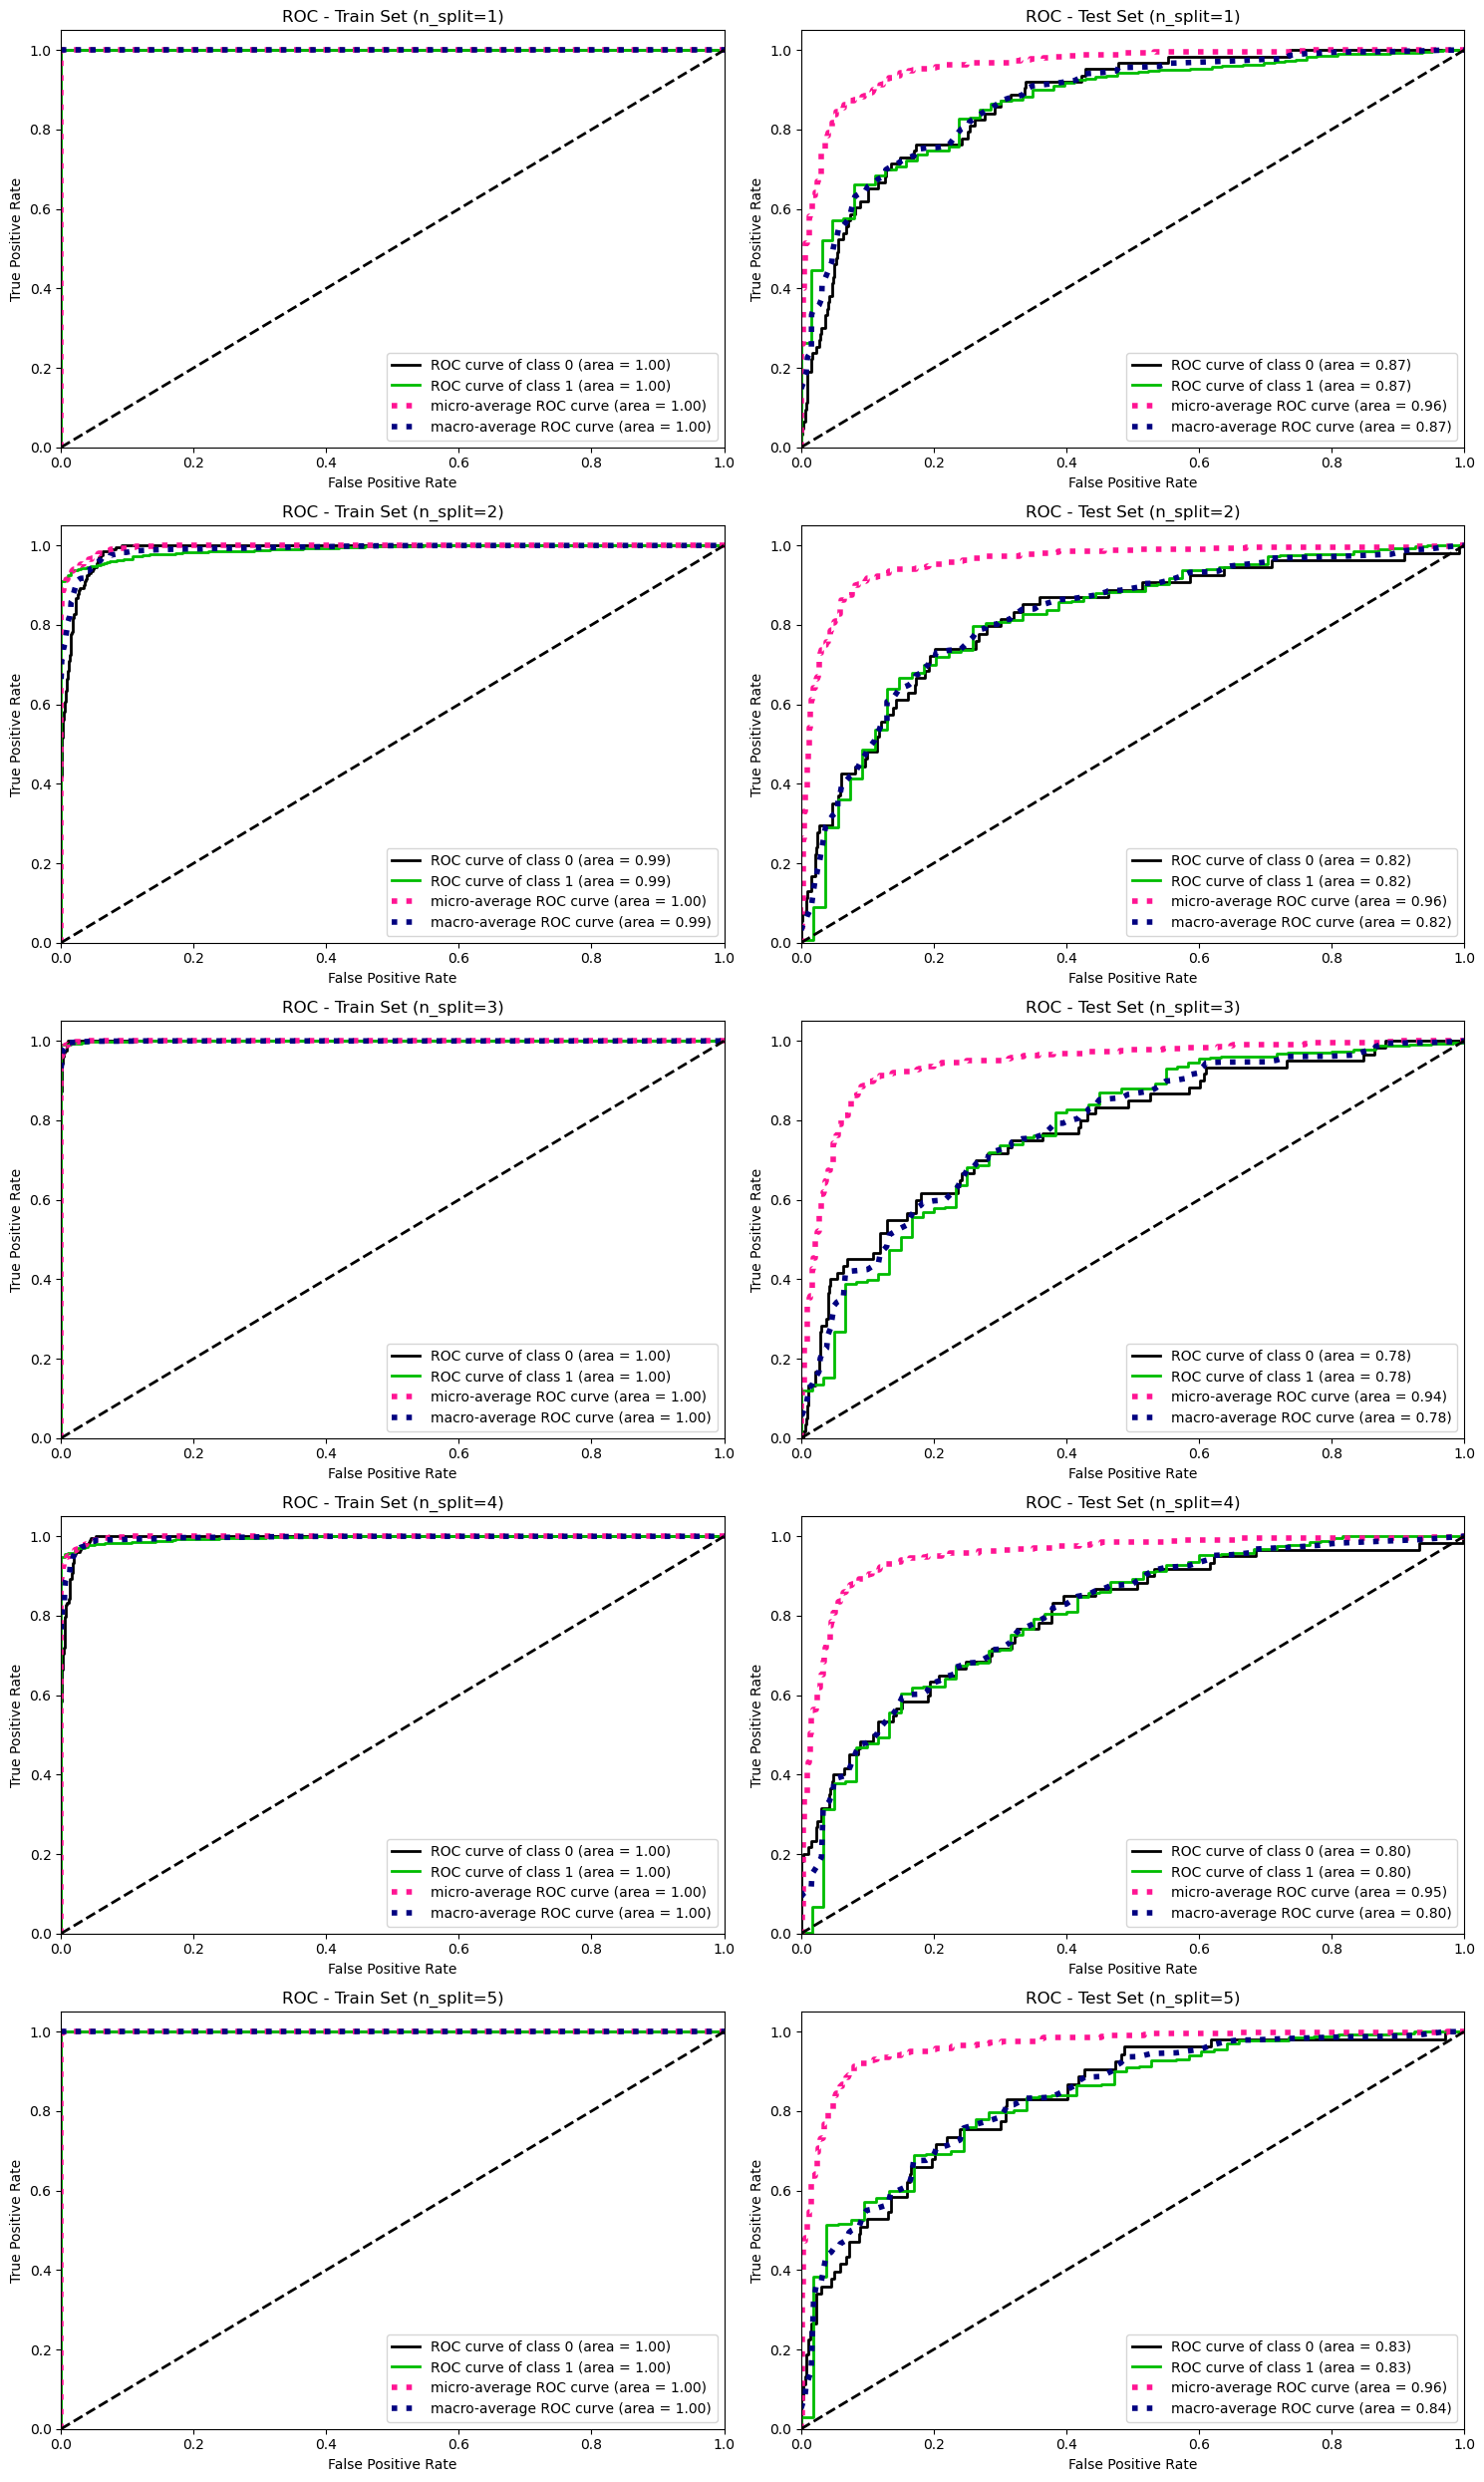

In [18]:
MyMultiTrainTester.plot_roc()

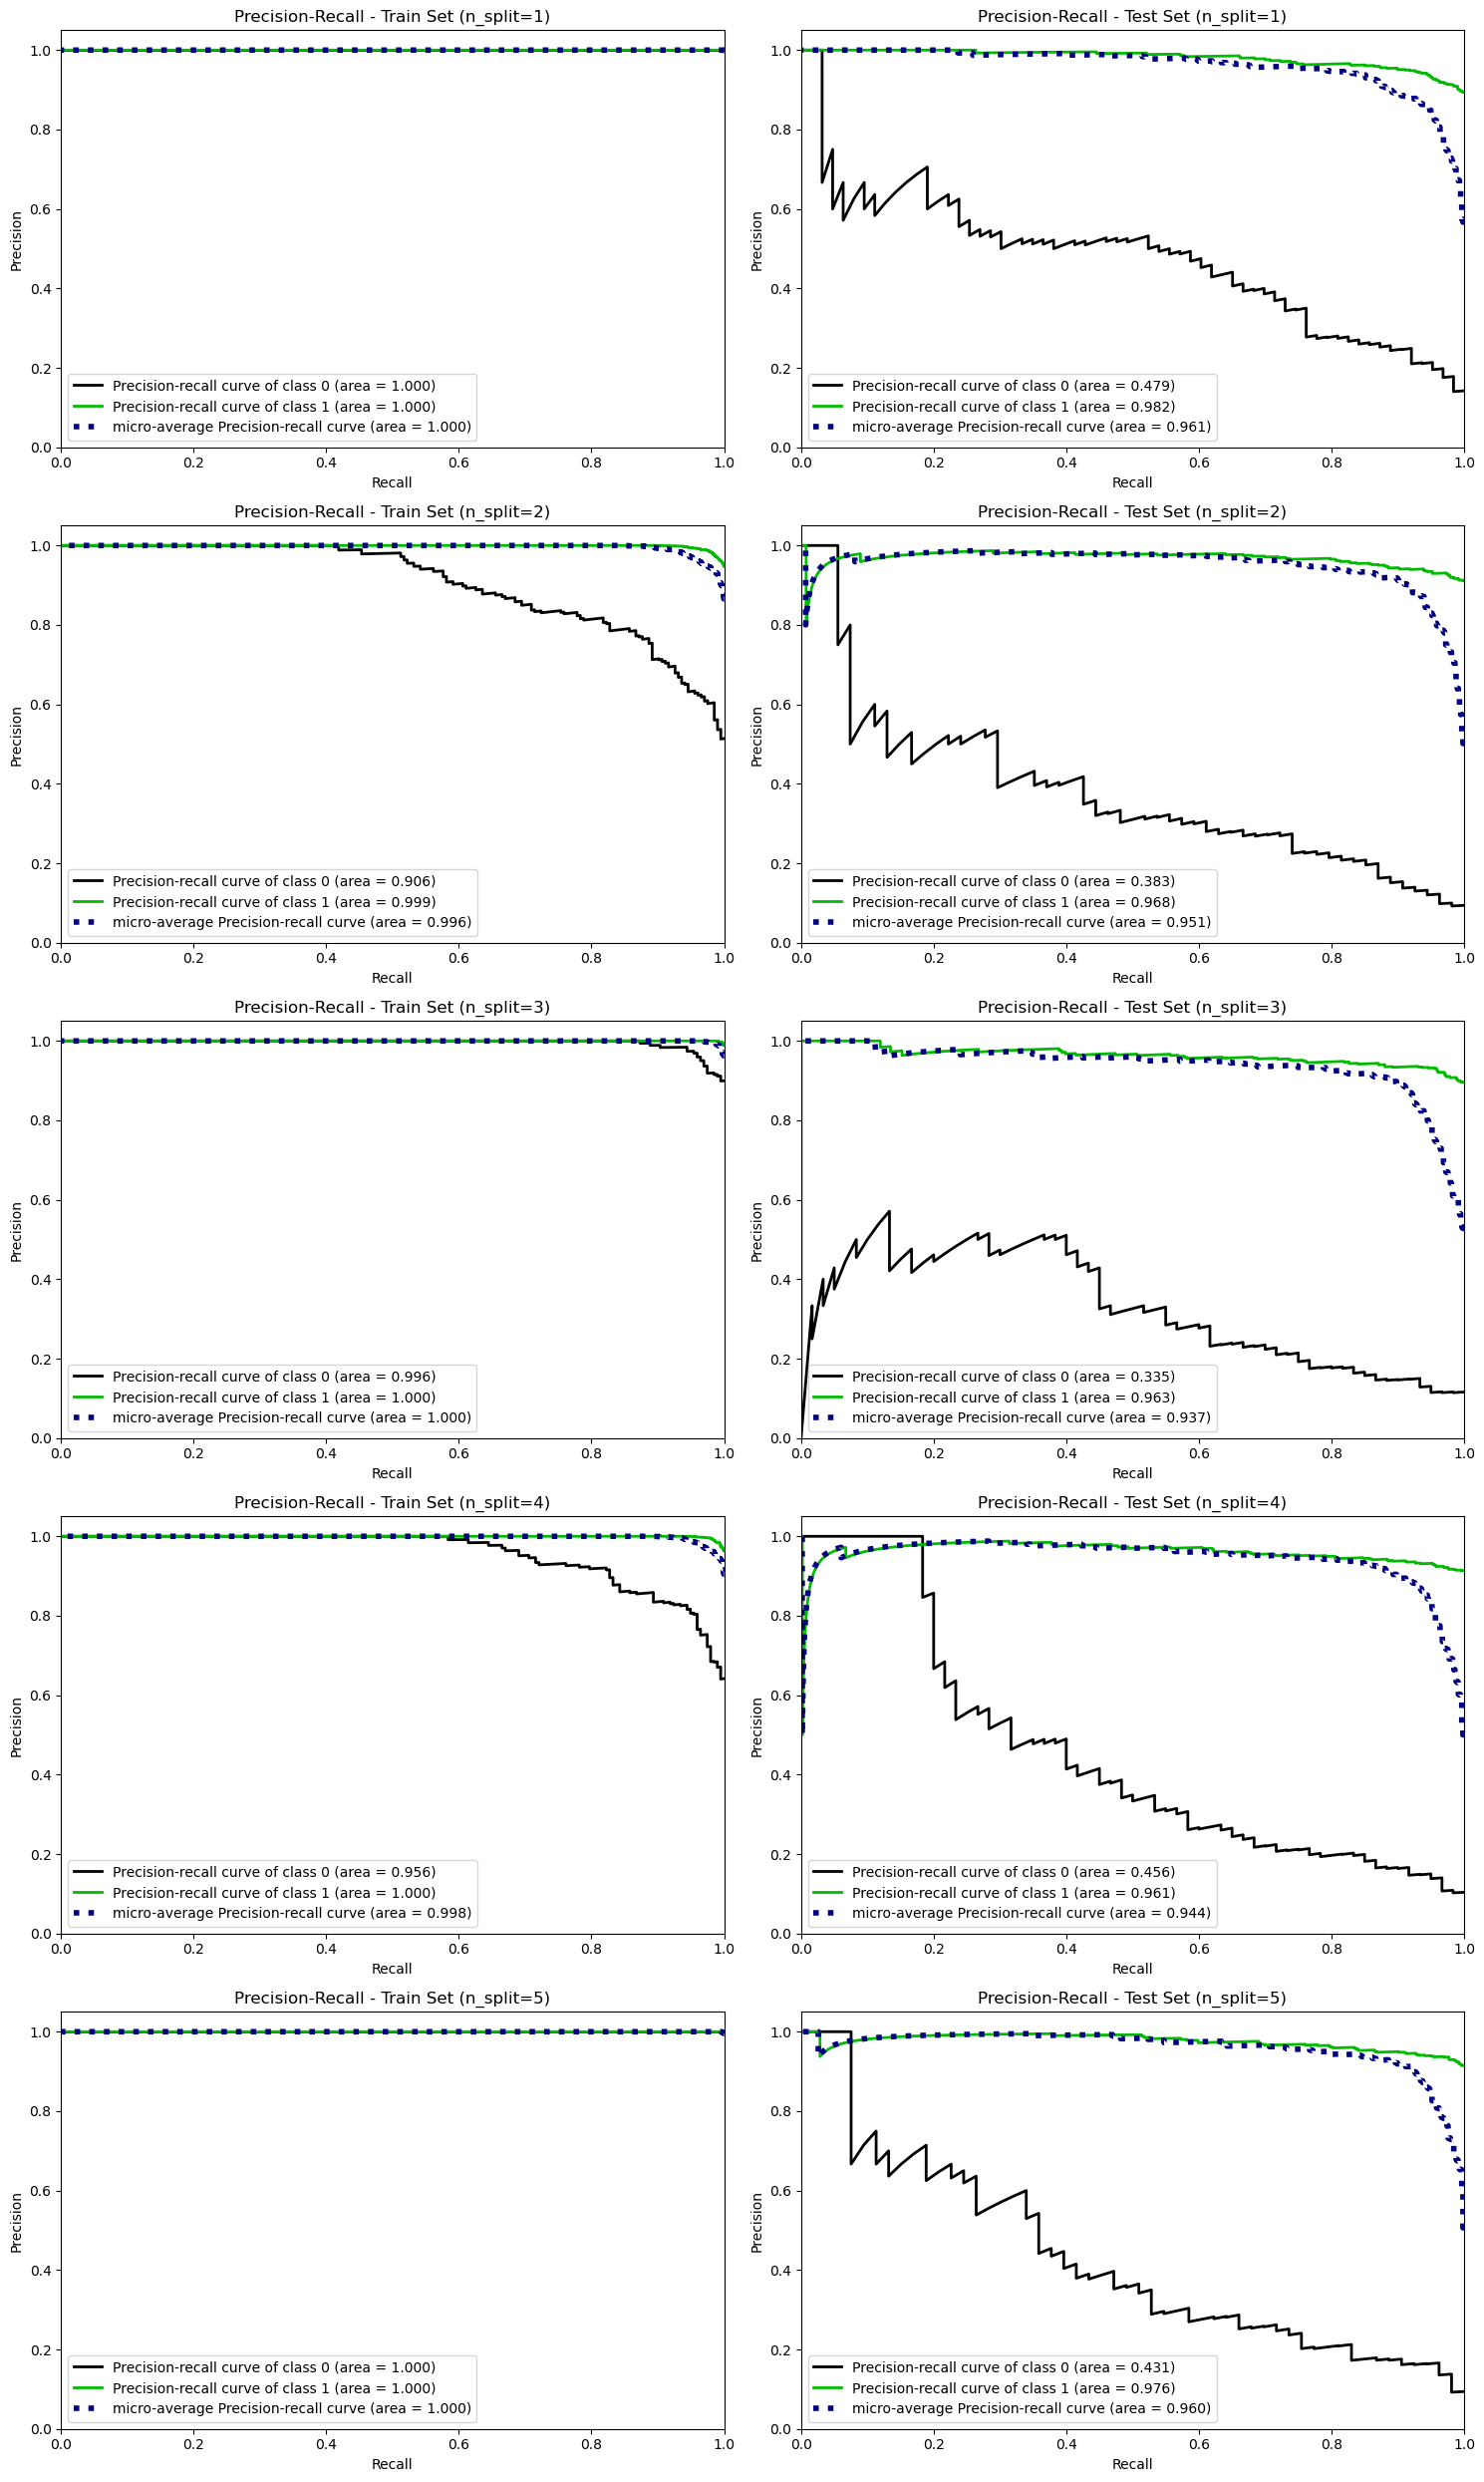

In [19]:
MyMultiTrainTester.plot_precrecall()